In [7]:
import anndata
import scanpy as sc
import numpy as np
import pandas as pd

from matplotlib.pyplot import rc_context

In [2]:
adata = sc.read('/lmh_data/data/sclab/syn22092838/snRNA_counts.mtx')
genes = pd.read_csv('/lmh_data/data/sclab/syn22092838/genes.csv', header=None)
scRNA_metadata = pd.read_csv('/lmh_data/data/sclab/syn22092838/snRNA_metadta.csv', index_col=0)

adata.obs_names = genes.values.reshape(-1)
adata.var = scRNA_metadata
adata = adata.T

adata = adata[adata.obs[adata.obs['celltype'].isin(['ASC', 'OPC', 'ODC'])].index,:]
# adata.obs.celltype = adata.obs.celltype.cat.rename_categories({'ASC': 'Astro'})
adata

View of AnnData object with n_obs × n_vars = 44548 × 36114
    obs: 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype'

In [3]:
train_set = np.load('/lmh_data/data/sclab/sclab/train_dataset.npy', allow_pickle=True)
scRNA_head = train_set[0]['scRNA_head']

In [4]:
gene_names = set(scRNA_head) & set(adata.var_names)
np.save('/lmh_data/data/sclab/sclab/AD/filter_genes.npy', np.array(gene_names))

In [6]:
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})
rna = rna[rna.obs['cell_type'].isin(['Astro', 'OPC', 'ODC']),:]
rna

View of AnnData object with n_obs × n_vars = 3793 × 50281
    obs: 'cell_type', 'domain'

In [8]:
def rna_pca(rna):
    rna.X = rna.layers["counts"].copy()
    sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
    sc.pp.normalize_total(rna)
    sc.pp.log1p(rna)
    sc.pp.scale(rna)
    sc.tl.pca(rna, n_comps=100, svd_solver="auto")

    sc.pp.neighbors(rna, metric="cosine")
    sc.tl.umap(rna)
    sc.tl.leiden(rna)

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/pandas/core/indexing.py:1628: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


0.83158994


/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be

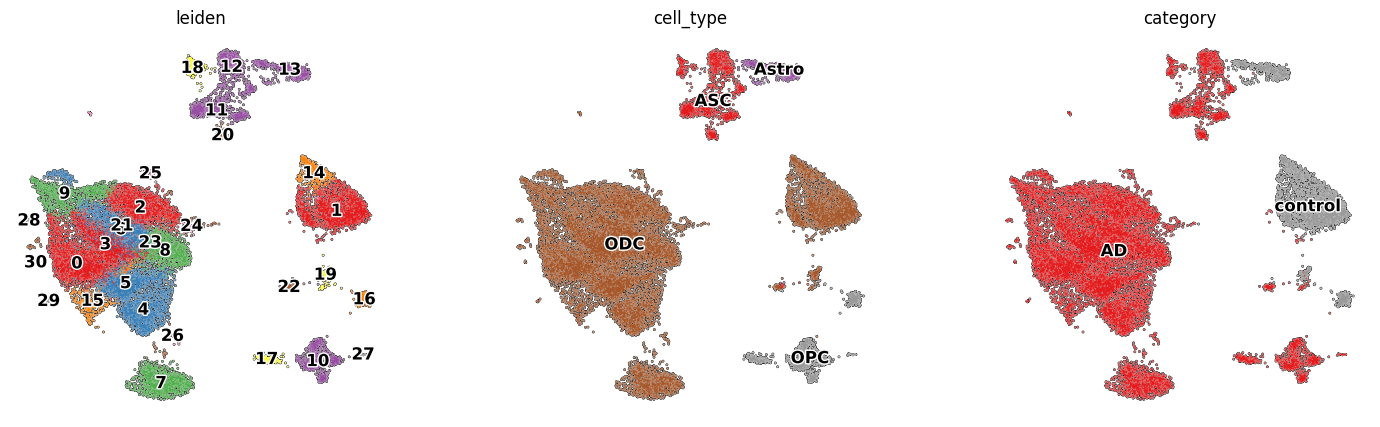

In [37]:
_rna = rna[:, list(gene_names)].copy()
_adata = adata[:, list(gene_names)].copy()
_adata = _adata[_adata.obs[_adata.obs['Diagnosis'] == 'Control'].index, :]

_adata.obs.loc[:, 'cell_type'] = _adata.obs.celltype
_rna.obs.loc[:, 'category'] = 'control'
_adata.obs.loc[:, 'category'] = 'AD'

# _proportion = _rna.X.max() / _adata.X.max()
# print(_proportion)
# _adata.X *= _proportion
# _adata.X = np.around(_adata.X.toarray()).astype(np.int32)

_combine = anndata.concat([_rna, _adata])
_combine.layers["counts"] = _combine.X.copy()

rna_pca(_combine)
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(_combine, color=['leiden', 'cell_type', 'category'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

In [ ]:
_rna = rna[:, list(gene_names)]
_adata = adata[:, list(gene_names)]

_adata.obs.loc[:, 'cell_type'] = _adata.obs.celltype
_rna.obs.loc[:, 'category'] = 'control'
_adata.obs.loc[:, 'category'] = 'AD'

_combine = anndata.concat([_rna, _adata])
_combine.layers["counts"] = _combine.X.copy()

rna_pca(_combine)
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(_combine, color=['leiden', 'cell_type', 'category'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

In [ ]:
_con = pd.DataFrame(_combine.obsp['connectivities'].toarray(), columns=_combine.obs_names, index=_combine.obs_names)
_con = _con.loc[
    _combine.obs[_combine.obs['category']=='control'].index,
    _combine.obs[_combine.obs['category']=='AD'].index
]

_con = _con[(_con.T != 0).any()].T
_con = _con[(_con.T != 0).any()].T
_con

In [ ]:
_dataset = []
for AD_case in _con.columns:
    _dataset.append({
        'scRNA': adata[AD_case, list(gene_names)].X.toarray()[0].astype(np.int32),
        'scRNA_head': adata[AD_case, list(gene_names)].var_names,
        'cell_type': adata[AD_case, list(gene_names)].obs['celltype'].values[0],
    })
np.save('/lmh_data/data/sclab/sclab/AD/eval_dataset.npy', _dataset)